# Aplicando *NeuralProphet* para séries temporais

Nesse projeto irei aplicar uma biblioteca chamada *Neural Prophet*, que é uma implementação *PyTorch* de Redes Neurais. A inspiração vem da biblioteca *Facebook Prophet* e o objetivo é o mesmo: tornar o processo de previsão de séries temporais algo mais amigável para profissionais que não possuam tanto conhecimento nesse tipo de modelagem.

Aqui irei aplicar essa biblioteca numa série temporal de Vendas de varejo de cerveja, vinhos e licores, que pode ser obtida [aqui](https://fred.stlouisfed.org/series/MRTSSM4453USN). Essa série possui 357 observações e tem periodicidade mensal, que vai de Janeiro de 1992 até Novembro de 2020.

## Instalando a biblioteca

Essa biblioteca pode ser instalada via *pip install neuralprophet* ou *pip install neuralprophet[live]*, porém tive erros com esses comandos, por isso o mais adequado é instalar com o comando abaixo.

In [1]:
!pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-et2otjq9
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-et2otjq9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 3.3MB/s 
  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-cp36-none-any.whl size=56717 sha256=b31fc3e1e95939ca1e9f6a695896411e15203ebab549f9a0e6335273cde4696b
  Stored in directory: /tmp/pip-ephem-wheel-cache-2n_plq_r/wheels/5a/29/25/58347b486c135e3aaa41f629bace08cfb3e92d08c65d2b4acf
Successfully built neuralprophet
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


## Importando bibliotecas

Importarei as bibliotecas padrões de análise de dados (caso sejam necessárias), o módulo da biblioteca e as métricas de erro para analisar o desempenho do modelo.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sct

from statsmodels.stats.stattools import jarque_bera
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import max_error, mean_squared_log_error, median_absolute_error


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importando os dados

In [3]:
liquor = pd.read_csv('liquor.csv')

Visualizando as vinte primeiras observações.

In [4]:
liquor.head(20)

,DATE,MRTSSM4453USN
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822
5,1992-06-01,1775
6,1992-07-01,1912
7,1992-08-01,1862
8,1992-09-01,1770
9,1992-10-01,1882


últimas vinte observações.

In [5]:
liquor.tail(20)

,DATE,MRTSSM4453USN
327,2019-04-01,4580
328,2019-05-01,5109
329,2019-06-01,5011
330,2019-07-01,5245
331,2019-08-01,5270
332,2019-09-01,4680
333,2019-10-01,4913
334,2019-11-01,5312
335,2019-12-01,6630
336,2020-01-01,4388


Dimensão da base de dados.

In [6]:
liquor.shape

(347, 2)

Tabela descritiva da série temporal.

In [7]:
liquor.describe()

,MRTSSM4453USN
count,347.000000
mean,3130.357349
std,1156.339445
min,1501.000000
25%,2136.000000
50%,2924.000000
75%,3815.000000
max,6630.000000


Não há valores faltantes na base de dados.

In [8]:
liquor.isna().sum()

DATE             0
MRTSSM4453USN    0
dtype: int64

Visualizando a séries temporal : podemos ver que ela possui uma tendência de crescimento ao longo dos anos e uma forte sazonalidade nos dados.

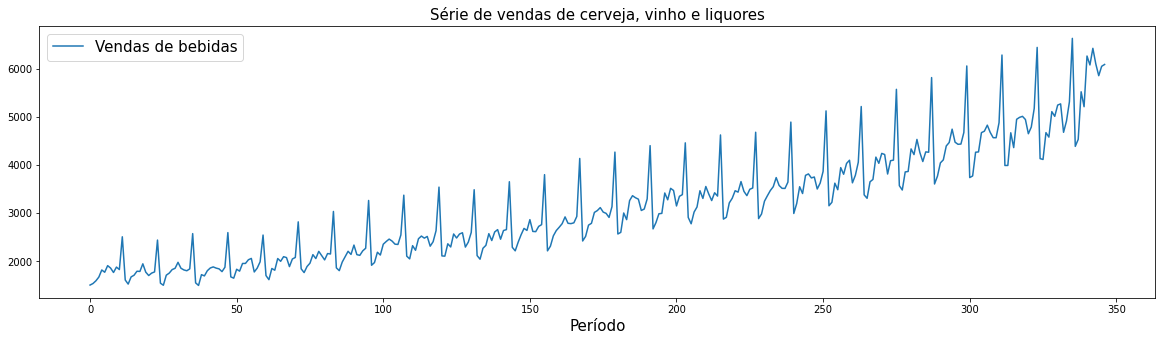

In [9]:
liquor.plot(figsize=(20,5))
plt.title('Série de vendas de cerveja, vinho e liquores',size=15)
plt.xlabel('Período',size=15)
plt.ylabel('')
plt.legend(['Vendas de bebidas'], fontsize=15)
plt.show()

Distribuição dos dados.

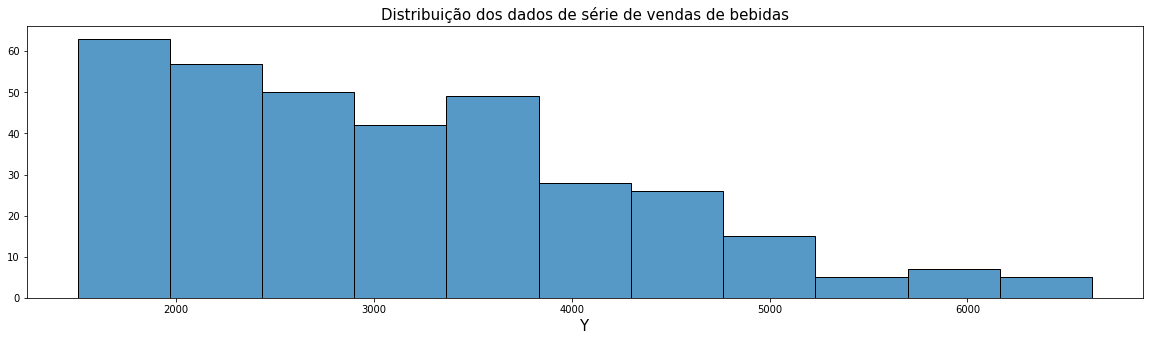

In [11]:
plt.figure(figsize=(20,5))
sns.histplot(liquor['MRTSSM4453USN'])
plt.title('Distribuição dos dados de série de vendas de bebidas',size=15)
plt.xlabel("Y",size=15)
plt.ylabel('');

## Criando o modelo

Antes de criar o modelo precisarei fazer duas coisas:

1) renomear as colunas: assim como na biblioteca *Facebook Prophet* é necessário renomear a coluna de datas como *ds* e a coluna com os dados da séries como *y*;

2) Separar os dados de treino e validação: uma parte dos dados para que o modelo seja treinado e depois as previsões possam ser geradas e uma parte final dos dados que serão comparados com as previsões, para analisar o desempenho do modelo por meio das métricas de avaliação.

Renomeando a base de dados.

In [12]:
liquor.columns = ['ds','y']

Conferindo se as colunas foram renomeadas.

In [13]:
liquor.columns

Index(['ds', 'y'], dtype='object')

### Separando os dados de treino e de teste (validação).

Aqui irei separar as 24 últimas observações (24 meses) da série para serem os dados de validação, ou seja, dados que o modelo não irá *ver*.

In [14]:
liquor_teste = liquor[323:347]
liquor_treino = liquor[:322]

Visualizando os dados de treino e validação.

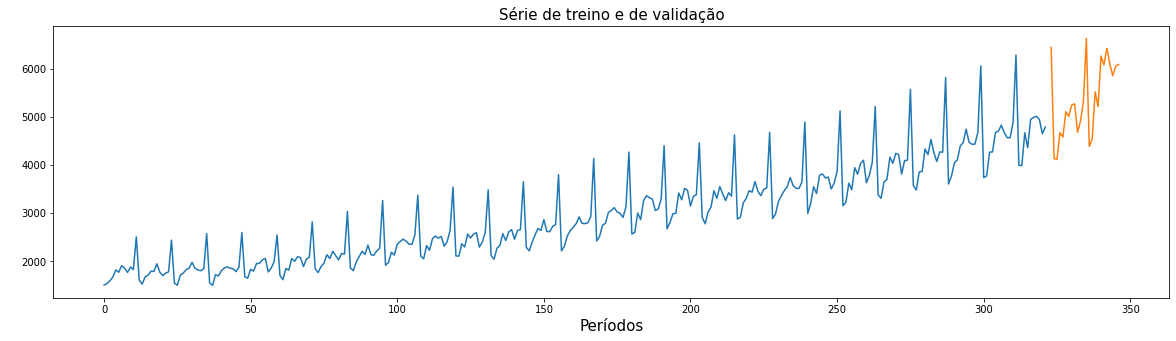

In [15]:
liquor_treino['y'].plot(figsize =(20,5))
liquor_teste['y'].plot()
plt.title('Série de treino e de validação',size=15)
plt.ylabel(" "),
plt.xlabel("Períodos", size=15);



Agora, com essas modificações, podemos iniciar gerando o modelo *NeuralProphet*.

Instanciando o modelo *NeuralProphet*, achei mais adequado colocar as sazonalidade na forma *multiplicativa* do que a padrão, que é a *aditiva*.

In [83]:
m3 = NeuralProphet(seasonality_mode='multiplicative', num_hidden_layers=10, d_hidden=10, learning_rate=0.1, batch_size=30, epochs=200)

Treinando o modelo *NeuralProphet*.

In [84]:
metrics = m3.fit(liquor_treino, freq='M', plot_live_loss=True) 

WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neuralprophet/forecaster.py", line 585, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[200/200]: 100%|██████████| 200/200 [00:05<00:00, 33.53it/s, SmoothL1Loss=0.000456, MAE=83.7, RegLoss=0]


Gerando as previsões do modelo.

In [85]:
future = m3.make_future_dataframe(liquor_treino, periods=24)
forecast = m3.predict(future)

Visualizando as previsões do modelo, vemos que, além das previsões são geradas as séries de componentes tendência e sazonalidade anual. O modelos entende que apenas esse componentes fazem parte da série, por isso os não são gerados os resíduos.

In [86]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly
0,2018-10-31,None,4772.549805,NaN,4775.820801,-0.000899
1,2018-11-30,None,6829.687012,NaN,4789.086914,0.559074
2,2018-12-31,None,4002.953613,NaN,4802.793945,-0.218317
3,2019-01-31,None,3950.447754,NaN,4816.501953,-0.235509
4,2019-02-28,None,4459.093262,NaN,4828.883301,-0.100221
5,2019-03-31,None,4490.527344,NaN,4842.590820,-0.095063
6,2019-04-30,None,4915.954102,NaN,4855.856445,0.016169
7,2019-05-31,None,4990.236816,NaN,4869.564453,0.032348
8,2019-06-30,None,5095.388672,NaN,4882.830566,0.056777
9,2019-07-31,None,5092.583496,NaN,4896.538086,0.052176


A biblioteca permite a plotagem de vários componentes da série, como no gráfico abaixo pode-se visualizar as previsões.

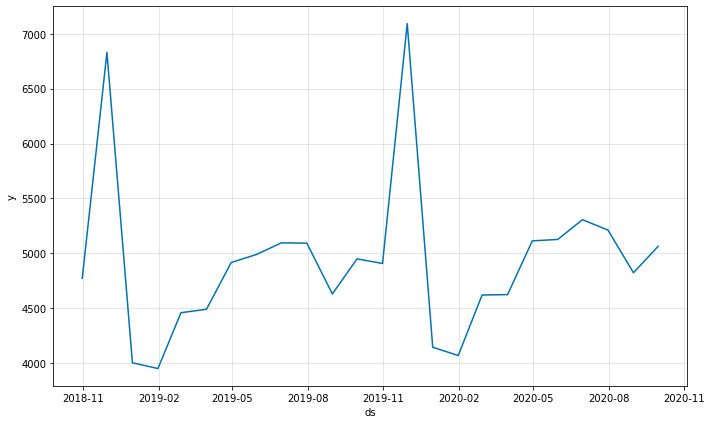

In [87]:
m3.plot(forecast);

Abaixo vemos os componentes tendência e sazonalidade separados.

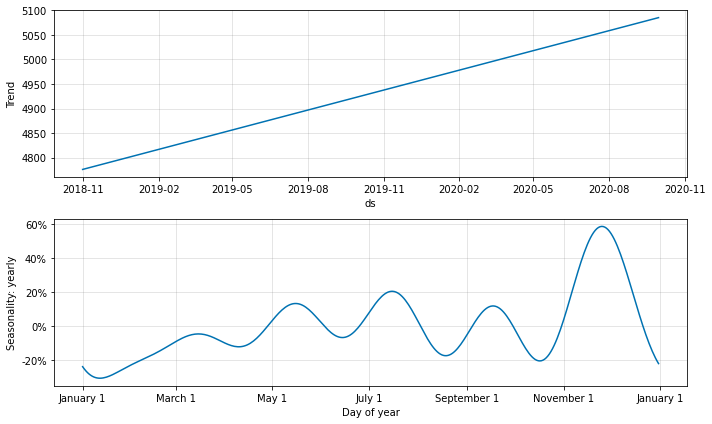

In [88]:
m3.plot_components(forecast);

Parâmetros do modelo.

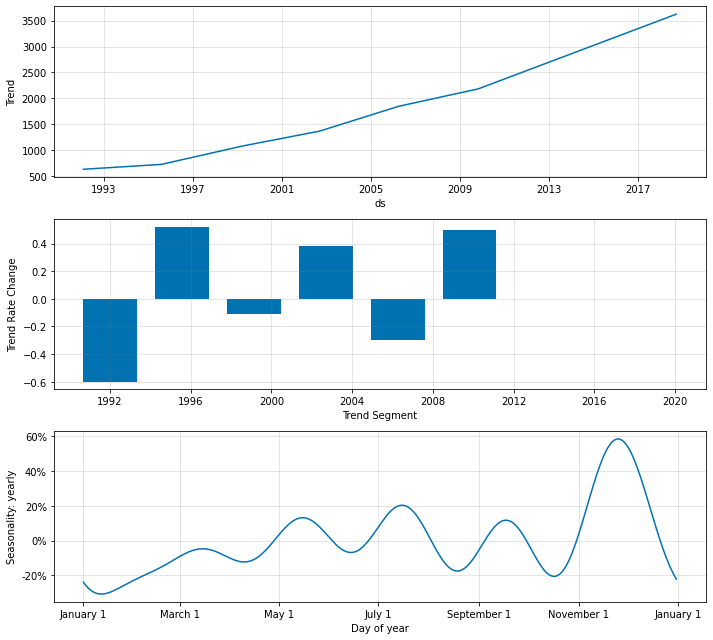

In [89]:
m3.plot_parameters();

### Análise de desempenho do modelo

Como explicitado anteriormente, uma parte final dos dados foi separada para validar o modelo, os últimos 24 meses. Agora irei comparar as 24 previsões do modelo com os 24 valores reais finais e ver como ele se saiu em prever o futuro da venda de cerveja, vinho e licores.

Primeiramente, irei separar as previsões em uma variável e indexarei ela ao índice da base de teste (ou validação).

In [90]:
forecast_y = forecast['yhat1']
forecast_y.index = liquor_teste.index

Comparar graficamente os resultados, pode-se ver que as previsões acompanham bem os valores reais e em alguns pontos chegam a cruzarem-se. Entretanto visualizar não basta, por isso irei utilizar métricas de ver o desempenho do modelo logo a seguir.

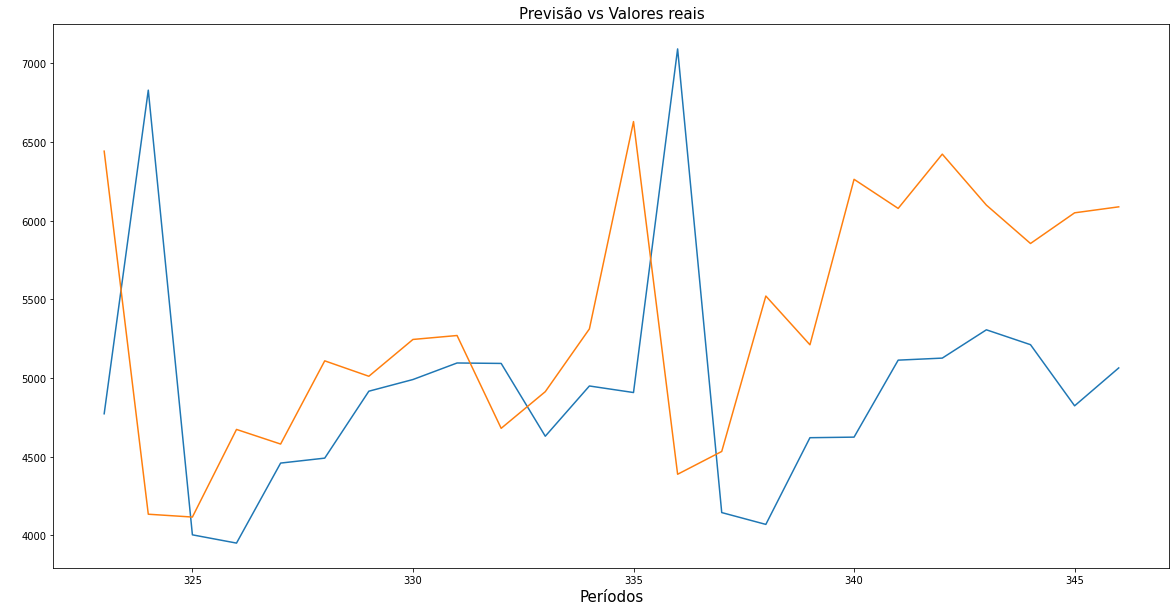

In [91]:
forecast['yhat1'].plot(figsize=(20,10))
liquor_teste['y'].plot()
plt.title('Previsão vs Valores reais',size=15)
plt.xlabel("Períodos",size=15)
plt.ylabel(" ");

Comparação com a série completa.

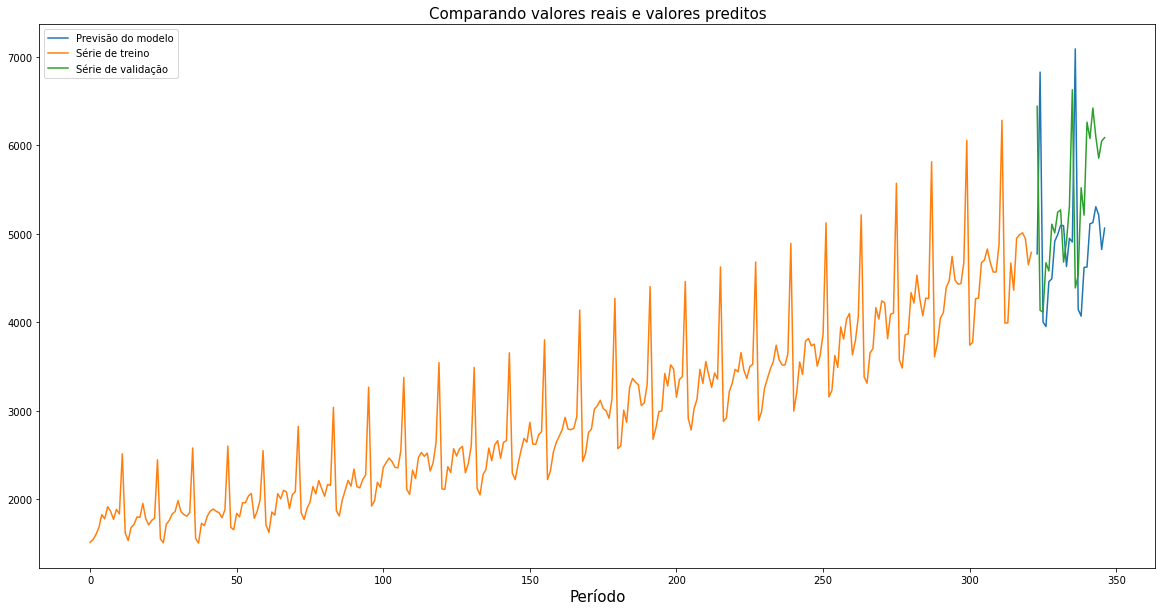

In [92]:
forecast['yhat1'].plot(figsize=(20,10))
liquor_treino['y'].plot()
liquor_teste['y'].plot()
plt.legend(['Previsão do modelo','Série de treino','Série de validação'], fontsize=10)
plt.title("Comparando valores reais e valores preditos",size = 15)
plt.xlabel('Período',size = 15);

Abaixo podemos ver as métricas de erro entre as previsões e os valores reais. O ideal é que os valores sejam zero, porém não existe modelo perfeito há sempre uam diferença entre esses resultados. Das métricas abaixo, a mais utilizada é o *RMSE* (raiz dos erros médio quadráticos), pois ele penaliza erros maiores.

In [93]:
print('Erro logarítmico médio quadrático :',mean_squared_log_error(liquor_teste['y'],forecast['yhat1']))
print('Erro médio quadrático :',mean_squared_error(liquor_teste['y'],forecast['yhat1']))
print('Raiz do erro médio quadrático :',mean_squared_error(liquor_teste['y'],forecast['yhat1'])**0.5)
print('Erro absoluto médio :',mean_absolute_error(liquor_teste['y'],forecast['yhat1']))
print('Erro absoluto mediano :',median_absolute_error(liquor_teste['y'],forecast['yhat1']))

Erro logarítmico médio quadrático : 0.047297092266348685
Erro médio quadrático : 1385492.3625280384
Raiz do erro médio quadrático : 1177.0693957996014
Erro absoluto médio : 915.3135477701823
Erro absoluto mediano : 682.921630859375


Outra forma de comparar os resultados é a observando as tabelas estatísticas do real e do previsto. Abaixo vemos que os resultados são bastante semelhantes, pois os valores das médias, desvios padrões e de alguns quartis estão bem próximos.

In [94]:
print('Tabela estatística da base de validação')
print(''*254)
print(liquor_teste['y'].describe())
print(''*254)
print('Tabela estatística da base das previsões')
print(''*254)
print(forecast['yhat1'].describe())

Tabela estatística da base de validação

count      24.000000
mean     5359.333333
std       772.353865
min      4116.000000
25%      4678.250000
50%      5257.500000
75%      6080.500000
max      6630.000000
Name: y, dtype: float64

Tabela estatística da base das previsões

count      24.000000
mean     4928.371674
std       738.979003
min      3950.447754
25%      4587.929932
50%      4911.756836
75%      5099.895996
max      7091.952148
Name: yhat1, dtype: float64


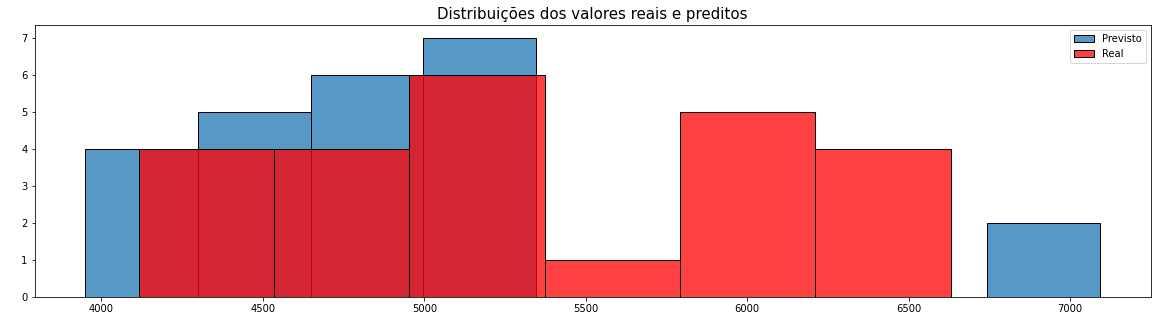

In [95]:
plt.figure(figsize=(20,5))
sns.histplot(forecast['yhat1'])
sns.histplot(liquor_teste['y'],color='red')
plt.title("Distribuições dos valores reais e preditos",size=15)
plt.legend(['Previsto','Real'])
plt.xlabel(' ')
plt.ylabel(' ');

Outra forma é verificar se há alguma semelhança entre esse valores é realizando teste estatísticos, sendo um deles o teste *t* para comparar média de amostras que tem por hipótese nula que as médias das amostras são iguais. 

Considerando que possuímos mais de 50 graus de liberdades e com 5% de nível de significância, observando a tabela *t-student* [aqui](https://sites.icmc.usp.br/francisco/SME0123/listas/Tabela_Dist_t.pdf), temos como limite da região de aceitação os valores -2.009 e +2.009 e nossa estatística ficou dentro desse intervalo, ou seja, a região de aceitação da hipótese nula, logo concluímos que as médias dos valores previstos e reais são estatisticamente iguais.

In [96]:
print('A estatística t-student do teste em módulo é:',np.absolute(sct.ttest_ind(liquor_teste['y'],forecast['yhat1'])[0]))
print('O p-valor:',sct.ttest_ind(liquor_teste['y'],forecast['yhat1'])[1])

A estatística t-student do teste em módulo é: 1.9751189596120657
O p-valor: 0.05427340775942751


## Conclusão

O modelo gerado pela biblioteca teve um bom desempenho com suas previsões e pode ser terinado com todos os dados da série e para gerar previsões para um futuro que não conhecemos. O que mais pode-se destacar dessa biblioteca é a sua simplicidade e facilidade para geração de modelos que não são de modo algum simples e facéis de trabalhar, que são as redes neurais, principalemente para problemas que envolvem séries temporais.